# Regression model

This notebook models the data.

References<br />
Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.<br />
https://github.com/fonnesbeck/multilevel_modeling

#### Import statements

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn
import mpld3
from mpld3 import plugins

In [ ]:
from pymc3 import glm, Model, NUTS, sample, forestplot, traceplot, summary, Normal, Uniform, Deterministic, StudentT, plot_posterior
from statsmodels.formula.api import ols

#### Variable definitions

In [4]:
data_filepath = "/Users/Jake/Desktop/innsbruck_dataset/all.csv"

## Load data

In [5]:
data = pd.read_csv(data_filepath)
data = data.loc[data.site<=30]

In [ ]:
data[['site', 'site_name', 'building_pavement_200m', 'forest_200m']].head()

sort data by site and then by visit

In [7]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

In [8]:
data_sorted[['site', 'site_name', 'biophony', 'forest_200m', 'temperature']].head(n=10)

,site,site_name,biophony,forest_200m,temperature
0,1,Lans,83.522323,70.934164,9.9
1,1,Lans,81.196749,70.934164,10.4
2,1,Lans,84.231717,70.934164,18.0
3,1,Lans,89.147379,70.934164,23.9
4,1,Lans,86.715442,70.934164,7.9
5,2,Hofwald,76.131350,97.068706,5.9
6,2,Hofwald,75.306785,97.068706,4.3
7,2,Hofwald,86.630363,97.068706,2.1
8,2,Hofwald,89.550034,97.068706,22.2
9,2,Hofwald,86.640584,97.068706,13.9


## Plot data

Let's first look at a pairwise plot of a subset of the data.

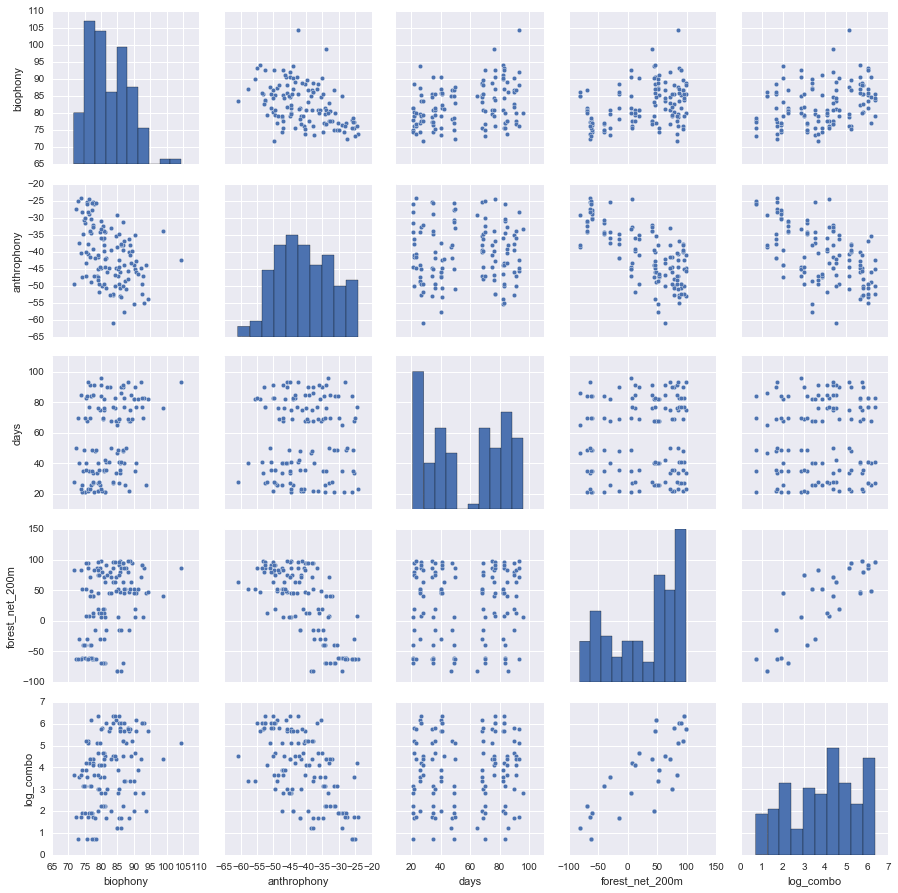

In [201]:
pairplot = seaborn.pairplot(data[['biophony', 'anthrophony', 'days', 'forest_net_200m', 'log_combo']])

/Users/Jake/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


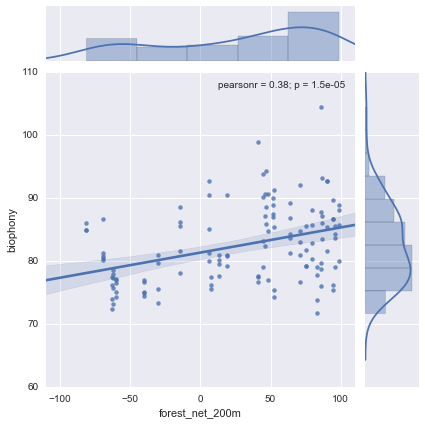

In [147]:
biophony_jointplot = seaborn.jointplot('forest_net_200m', 'biophony', data=data, kind='reg', 
                                       xlim=(-110, 110), ylim=(60, 110))

/Users/Jake/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


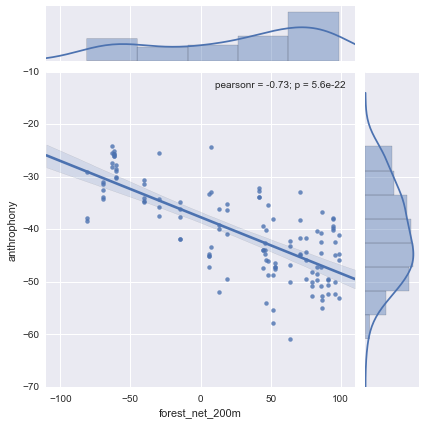

In [146]:
anthrophony_jointplot = seaborn.jointplot('forest_net_200m', 'anthrophony', data=data, kind='reg', 
                                          xlim=(-110, 110), ylim=(-70, -10))

As the boxplots show, repeated measurements of anthrophony and biophony varry little at some sites and greatly at others.

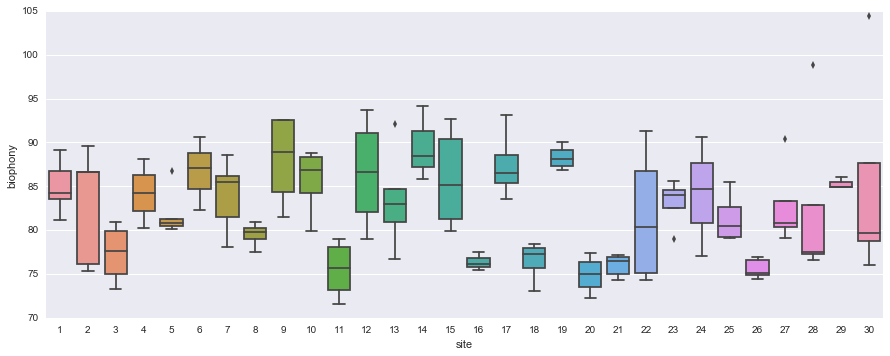

In [116]:
biophony_boxplot = seaborn.boxplot('site', 'biophony', data=data)
biophony_boxplot.figure.set_figwidth(15)

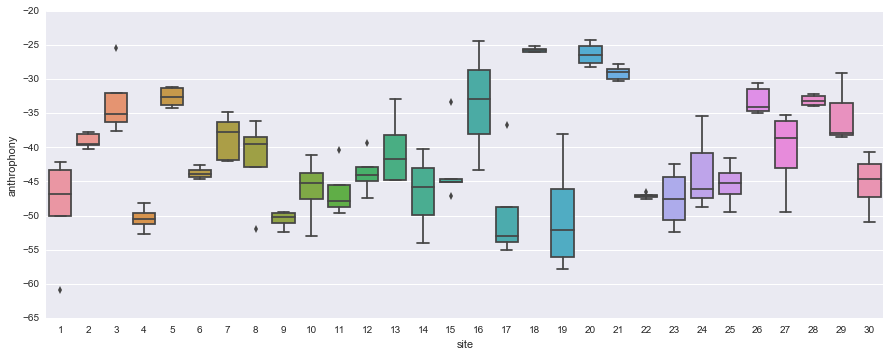

In [10]:
anthrophony_boxplot = seaborn.boxplot('site', 'anthrophony', data=data)
anthrophony_boxplot.figure.set_figwidth(15)

## Complete pooling

$$y_i = \alpha + \beta x_i$$

In [148]:
with Model() as pooled_model:
    glm.glm("biophony ~ forest_net_200m", data)
    pooled_trace = sample(1000, NUTS())

100%|██████████| 1000/1000 [00:01<00:00, 572.22it/s]


In [149]:
intercept0 = pooled_trace['Intercept'][500:].mean()
slope0 = pooled_trace['forest_net_200m'][500:].mean()

In [213]:
intercept0

81.299438750137043

In [214]:
slope0

0.039644337292783174

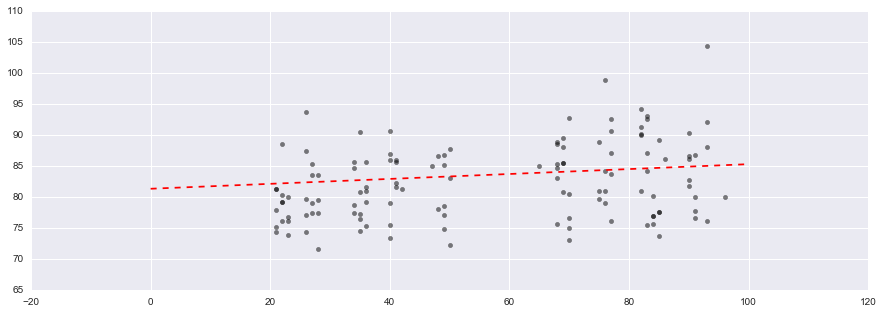

In [151]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data.days, data.biophony, marker='o', color='black', alpha=0.5)
x_days = np.linspace(0, 100)
ax.plot(x_days, intercept0 + slope0*x_days, 'r--')
ax.set_xlabel = "days since project start"
ax.set_xlabel = "biophony"

## No pooling

$$y_{ij} = \alpha_j + \beta_j x_i$$

NOTE: something is off with the ols calculation

In [152]:
unpooled_fit = ols('biophony ~ C(site) * days - 1', data).fit()
unpooled_estimates = unpooled_fit.params

In [72]:
#unpooled_estimates = unpooled_estimates.rename(dict(zip(unpooled_estimates.index.values, 
#                    [x[10:-1] or x for x in unpooled_estimates.index.values])))
#unpooled_se = unpooled_fit.HC3_se.rename(dict(zip(unpooled_fit.HC3_se.index.values, 
#                    [x[10:-1] or x for x in unpooled_fit.HC3_se.index.values])))

In [153]:
sample_sites = (2, 9, 11, 15, 17, 18, 26, 30)

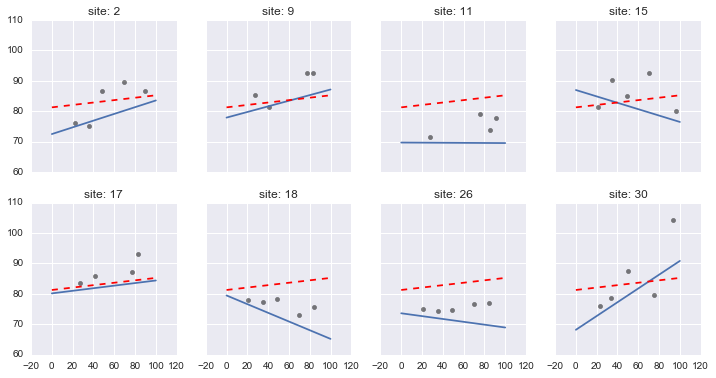

In [154]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    ax[i].scatter(x + np.random.randn(len(x))*0.01, y, color='black', alpha=0.5)
    
    # No pooling model
    m, b = unpooled_estimates[['C(site)[T.{0}]:days'.format(site), 'C(site)[{0}]'.format(site)]]
    
    # Plot both models and data
    xvals = np.linspace(0, 100)
    ax[i].plot(xvals, (m * xvals) + b)
    ax[i].plot(xvals, (slope0 * xvals) + intercept0, 'r--')
    ax[i].set_title("site: {0}".format(site))

## Partial pooling (empty model)

$$y_{ij} = \beta_{0j} + r_{ij}$$
$$\beta_{0j} = \gamma_{00} + u_{0j}$$

In [155]:
sites = np.copy(data.site.values) - 1

In [167]:
#sites_lookup = dict()
#for i, s in enumerate(set(sites)):
#    sites_lookup["{0}".format(s)] = i

In [169]:
#sites_index = np.empty_like(sites)
#for i, site in enumerate(sites):
#    sites_index[i] = sites_lookup[str(site)]

In [156]:
with Model() as partial_pooling:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony)

In [157]:
with partial_pooling:
    step = NUTS()
    partial_pooling_samples = sample(2000, step)

100%|██████████| 2000/2000 [00:04<00:00, 494.61it/s]


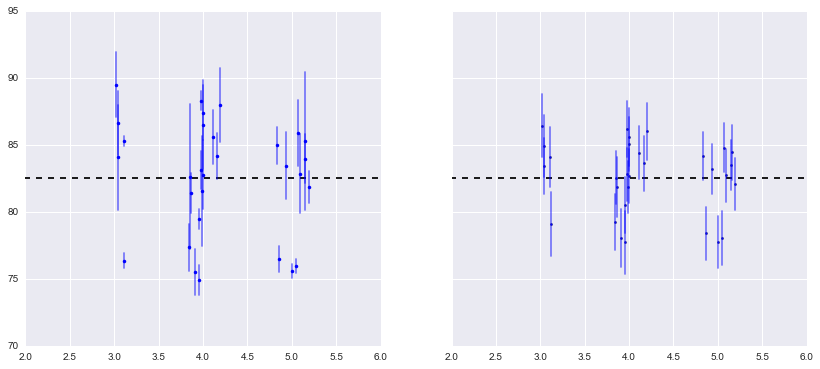

In [158]:
sample_trace = partial_pooling_samples['a'][-1000:]

fig, ax = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, sites = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=sites)

n_site = data.groupby('site')['biophony'].count()
unpooled_means = data.groupby('site')['biophony'].mean()
unpooled_sd = data.groupby('site')['biophony'].std()
unpooled = pd.DataFrame({'n':n_site, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

ax[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    ax[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-', alpha=0.5)
ax[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

samples, sites = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
ax[1].scatter(n_site.values + jitter, means, marker='.')
ax[1].set_xlim(2, 6)
ax[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_site.values, means, sd):
    ax[1].plot([n+j]*2, [m-s, m+s], 'b-', alpha=0.5)

## Varying intercepts

$$y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij}$$
$$\beta_{0j} = \gamma_{00} + u_{0j}$$
$$\beta_{1j} = \gamma_{10}$$

In [159]:
sites = np.copy(data.site.values) - 1

In [160]:
with Model() as varying_intercept:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    # Common slope
    b = Normal('b', mu=0., tau=0.0001)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites] + b * data.days
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony)

In [161]:
with varying_intercept:
    step = NUTS()
    varying_intercept_samples = sample(2000, step)

100%|██████████| 2000/2000 [00:03<00:00, 516.17it/s]


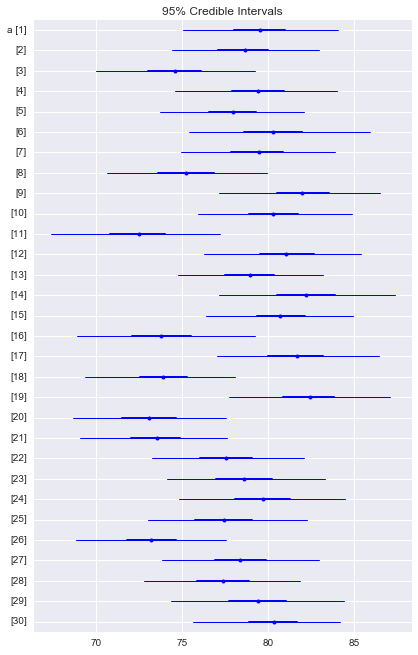

In [162]:
plt.figure(figsize=(6,10))
forestplot(varying_intercept_samples, varnames=['a'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1341ca908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13f101240>]], dtype=object)

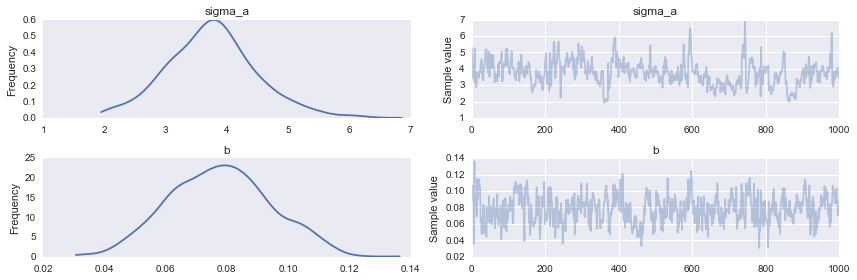

In [163]:
traceplot(varying_intercept_samples[-1000:], varnames=['sigma_a', 'b'])

In [164]:
summary(varying_intercept_samples[-1000:], varnames=['b'])


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.078            0.017            0.001            [0.046, 0.109]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.047          0.066          0.078          0.089          0.110



(-10, 110)

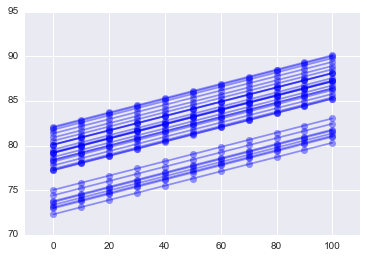

In [165]:
xvals = np.arange(0, 110, 10)
bp = varying_intercept_samples['a'].mean(axis=0)
mp = varying_intercept_samples['b'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-10, 110)

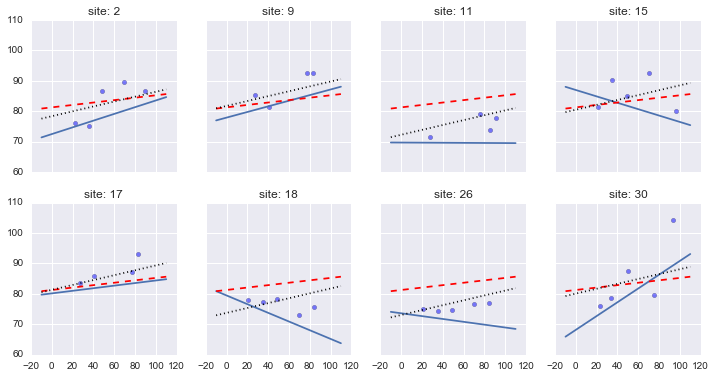

In [166]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    
    # Plot county data
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    ax[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.5)
    
    # No pooling model
    m, b = unpooled_estimates[['C(site)[T.{0}]:days'.format(site), 'C(site)[{0}]'.format(site)]]
    
    xvals = np.linspace(-10, 110)
    # Unpooled estimate
    ax[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    ax[i].plot(xvals, slope0*xvals+intercept0, 'r--')
    # Partial pooling esimate
    ax[i].plot(xvals, mp*xvals+bp[site-1], 'k:')
    ax[i].set_title("site: {0}".format(site))

# Varying slope

$$y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij}$$
$$\beta_{0j} = \gamma_{00}$$
$$\beta_{1j} = \gamma_{10} + u_{1j}$$

In [167]:
sites = np.copy(data.site.values) - 1

In [168]:
with Model() as varying_slope:
    
    # Priors
    mu_b = Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Model intercept
    a = Normal('a', mu=0., tau=0.0001)
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a + b[sites] * data.days
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony)

In [169]:
with varying_slope:
    step = NUTS()
    varying_slope_samples = sample(2000, step)

100%|██████████| 2000/2000 [01:34<00:00, 21.05it/s]


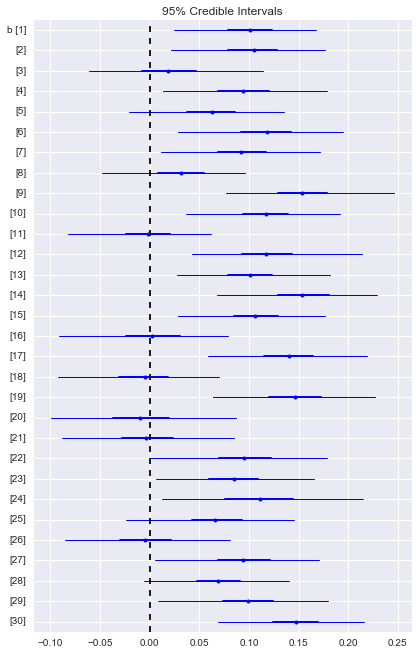

In [170]:
plt.figure(figsize=(6,10))
forestplot(varying_slope_samples, varnames=['b'])

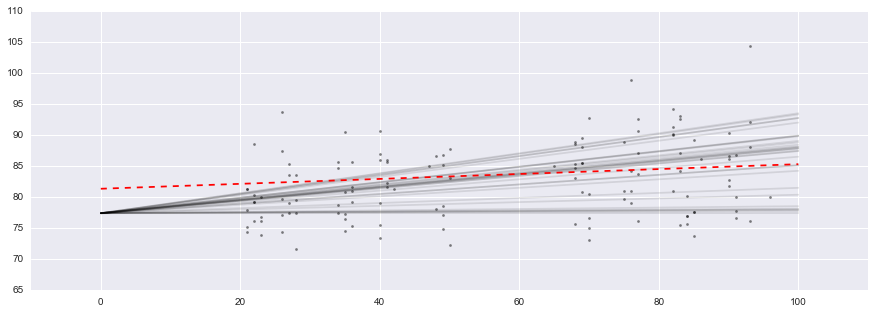

In [171]:
fig, ax = plt.subplots(figsize=(15, 5))

# all data
ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)

# varying slopes
x_days = np.arange(0, 110, 100)
b = varying_slope_samples['a'].mean()
m = varying_slope_samples['b'].mean(axis=0)
for mi in m:
    ax.plot(x_days, mi*x_days + b, marker=None, color='black', alpha=0.1)
ax.set_xlim(-10, 110)

# pooled
plt.plot(x_days, intercept0 + slope0*x_days, marker=None, color='red', linestyle='--')

## Varying slope and intercept

$$y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij}$$
$$\beta_{0j} = \gamma_{00} + u_{0j}$$
$$\beta_{1j} = \gamma_{10} + u_{1j}$$

In [172]:
sites = np.copy(data.site.values) - 1

In [173]:
with Model() as varying_intercept_slope:
    
    # Priors    
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    mu_b = Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites] + b[sites] * data.days
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony)

In [174]:
with varying_intercept_slope:
    step = NUTS()
    varying_intercept_slope_samples = sample(2000, step)

100%|██████████| 2000/2000 [02:57<00:00, 11.29it/s]


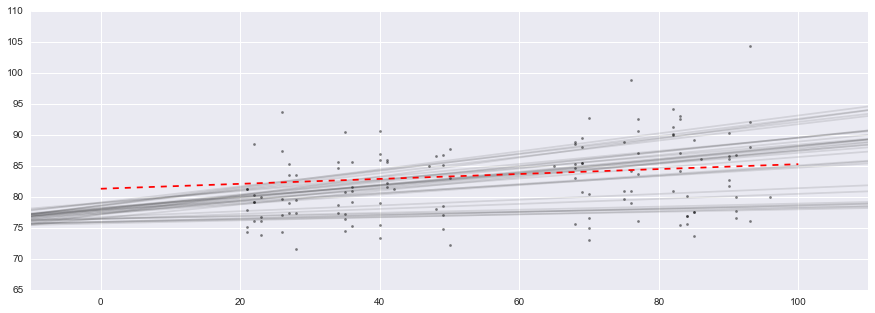

In [175]:
fig, ax = plt.subplots(figsize=(15, 5))

# all data
ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)

# varying slopes
x_days = np.arange(0, 110, 100)
b = varying_intercept_slope_samples['a'].mean(axis=0)
m = varying_intercept_slope_samples['b'].mean(axis=0)
for bi,mi in zip(b,m):
    ax.plot(xvals, mi*xvals + bi, marker=None, color='black', alpha=0.1)
ax.set_xlim(-10, 110)

# pooled
plt.plot(x_days, intercept0 + slope0*x_days, marker=None, color='red', linestyle='--')

## Model 3

In [9]:
sites = np.copy(data_sorted.site.values) - 1

In [186]:
#data['log_combo'] = data['combo'].apply(np.log)

In [10]:
data_sorted['biophony_centered'] = data_sorted.biophony - data_sorted.biophony.mean()

In [11]:
data_sorted['weeks_centered'] = (data_sorted.days - data_sorted.days.mean())/7

In [12]:
data_sorted['forest_net_200m'] = data_sorted.forest_200m - data_sorted.building_pavement_200m

In [13]:
data_sorted['forest_net_200m_centered'] = data_sorted.forest_net_200m - data_sorted.forest_net_200m.mean()

$$
\begin{align}
\text{level 1} \\
y_i \sim \mathcal{N}(\alpha_{j[i]} + \beta_{j[i]} x_{i}, \sigma^2_y), \\
\text{for $i = 1,...,n$} \\
\text{level 2} \\
\alpha_j \sim \mathcal{N}(\gamma_{00} + \gamma_{01} u_{j}, \sigma^2_{\alpha}), \\
\beta_{j} \sim \mathcal{N}(\gamma_{10} + \gamma_{11} u_{j}, \sigma^2_{\beta}), \\
\text{for $j = 1,...,J$}
\end{align}
$$
where $x_i$ is the measurement-level days indicator and $u_j$ is the site-level land cover indicator

In [14]:
with Model() as model_3:
    
    # intercept
    g_00 = Normal('g_00', mu=0, tau=0.001)
    g_01 = Normal('g_01', mu=0, tau=0.001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    mu_a = g_00 + (g_01 * data_sorted.forest_net_200m_centered.unique())
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    
    # slope
    g_10 = Normal('g_10', mu=0, tau=0.001)
    g_11 = Normal('g_11', mu=0, tau=0.001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    mu_b = g_10 + (g_11 * data_sorted.forest_net_200m_centered.unique())
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # model error (data-level)
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # expected values
    y_hat = a[sites] + (b[sites] * data_sorted.weeks_centered)
    
    # likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_sorted.biophony_centered)

In [15]:
with model_3:
    step = NUTS()
    model_3_samples = sample(2000, step)

100%|██████████| 2000/2000 [00:26<00:00, 74.70it/s]


In [16]:
trace = model_3_samples[-1000:]
a_means = trace['a'].mean(axis=0)
b_means = trace['b'].mean(axis=0)

In [17]:
fig, ax = plt.subplots()
slope_points = ax.scatter(data_sorted.forest_net_200m_centered.unique(), a_means, color='black', alpha=0.4)
g00 = trace['g_00'].mean()
g01 = trace['g_01'].mean()
x_forest = np.linspace(-110, 80)
ax.plot(x_forest, g00 + (g01 * x_forest), color='black', linestyle='--')
ax.set_xlim(-120, 90)

slope_point_labels = ["{0}: {1:0.2f}".format(n, s) for n, s in zip(data_sorted.site_name.unique(), a_means)]
tooltip = plugins.PointLabelTooltip(slope_points, slope_point_labels)
plugins.connect(fig, tooltip)

a_se = trace['a'].std(axis=0)
for xi, m, se in zip(data_sorted.forest_net_200m_centered.unique(), a_means, a_se):
    plt.plot([xi, xi], [m-se, m+se], color='black', alpha=0.1)
ax.set_xlabel('net forest within a 200 meter radius'); plt.ylabel('intercept estimate (biophony)')

mpld3.display(fig)

In [18]:
fig, ax = plt.subplots()
slope_points = ax.scatter(data_sorted.forest_net_200m_centered.unique(), b_means, color='black', alpha=0.4)
g10 = trace['g_10'].mean()
g11 = trace['g_11'].mean()
x_forest = np.linspace(-110, 80)
ax.plot(x_forest, g10 + (g11 * x_forest), color='black', linestyle='--')
ax.set_xlim(-120, 90)

slope_point_labels = ["{0}: {1:0.2f}".format(n, s) for n, s in zip(data_sorted.site_name.unique(), b_means)]
tooltip = plugins.PointLabelTooltip(slope_points, slope_point_labels)
plugins.connect(fig, tooltip)

b_se = trace['b'].std(axis=0)
for xi, m, se in zip(data_sorted.forest_net_200m_centered.unique(), b_means, b_se):
    plt.plot([xi, xi], [m-se, m+se], color='black', alpha=0.1)
ax.set_xlabel('net forest within a 200 meter radius'); plt.ylabel('slope estimate (biophony)')

mpld3.display(fig)

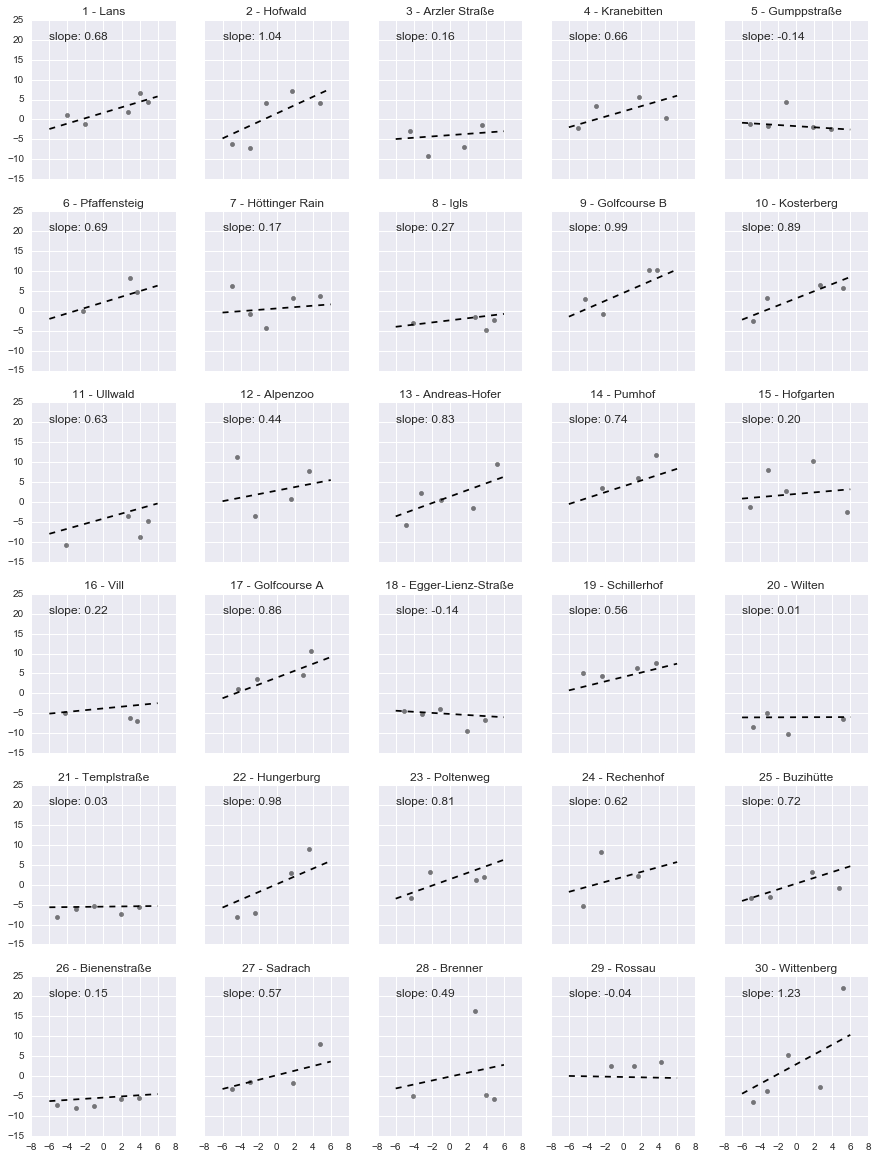

In [23]:
fig, ax = plt.subplots(6, 5, figsize=(15, 20), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(data_sorted.site.unique()):
    
    # observed data (points)
    y = data_sorted.biophony_centered[data_sorted.site==site]
    x = data_sorted.weeks_centered[data_sorted.site==site]
    ax[i].scatter(x + np.random.randn(len(x))*0.01, y, color='black', alpha=0.5)
    
    # model estimate (line)
    x_days = np.linspace(-6, 6, 2)
    ax[i].plot(x_days, a_means[i] + (b_means[i] * x_days), color='black', linestyle='--')
    ax[i].set_title("{0} - {1}".format(site, data_sorted.site_name[data_sorted.site == site].unique()[0]))
    ax[i].text(-6, 20, "slope: {0:.02f}".format(b_means[i]))